# 5. Stochastic semantics of biological circuits

<hr>
This course is derived from the course Biological Circuit Design by Michael Elowitz and Justin Bois, 2020 at Caltech. The original course material has been changed by Matthias Fuegger and Thomas Nowak.
<hr>

This lecture covers:

**Concepts**

- Bio chemical reaction networks (BCRNs) to describe species and reactions among them
- The chemical master equation: definition and procedural formulation
- The Gillespie algorithm to sample from the solution of the master equation

**Techniques**

- Stochastic simulation of reaction networks
- Profiling of code for optimization

<hr>

Let's start by importing libraries we will need:

In [1]:
# multiprocessing & progress
import joblib
import tqdm

# numbers
import numpy as np
import scipy.stats as st
import numba

# plotting
import matplotlib.pyplot as plt
figsize = (5,4)

# profiler
# -- install if necessary --
#
# by conda (uncomment):
# %conda install line_profiler
#
# or by pip (uncomment):
# %pip install line_profiler
#
# -- end install --
%load_ext line_profiler

## Sampling from distributions

### Flipping coins
Let's start with an example of someone doing $n$ coin flips.
The output of each coin-flip is either heads $H$ or tails $T$. 
Let the **sample space** $\Sigma = \{H,T\}^n$ be the set of all possible sequences.
Events are described by an **event space** $F$ that, here, contains all subsets of $\Sigma$.
For example, $E = \{T^n, H^n\} \in F$ is the event that either all flips resulted in heads or
all in tails.
Finally events are assigned **probabilities** by a function $P: F \to [0,1]$.
In general such functions are restricted to [follow three axioms](https://en.wikipedia.org/wiki/Probability_axioms).
In our case, we will assume that:
* Heads are assumed to occur **with probability** $p \in [0,1]$ in a single round.
  Let $X_i$, with $1 \leq i \leq n$, be the outcome of the flip in round $i$.
  We can now write $P(X_i = H)$ to denote the event that round $i$ resulted in
    heads.
  This is short for $P(E)$ with $E = \left\{ s \in \{H,T\}^n \mid s_i = H \right\} \subseteq F$.
  We have,
  $$
  P(X_i = H) = p \quad\text{ and }\quad P(X_i = T) = 1-p\enspace.
  $$
* Flips in rounds are independent.
  Two events $E_1$ and $E_2$ are **independent** if $P(E_1 \cap E_2) = P(E_1) \cdot P(E_2)$.
  Thus, for $A,B \in \Sigma$,
  $$
  P(X_i = A \wedge X_j = B) = P(X_i = A) \cdot P(X_j = B)\enspace,
  $$
  where we denoted events by Boolean formulas rather than sets; the sets
  are defined as the intersection of the sets $X_i = A$ and $X_j = B$.


### Distribution of flipping coins

It can be shown that the probability of having $k$ heads in a sample is,
let's denote it by $P(\mbox{heads} = h; n,p)$, is
$$
P(\mbox{heads} = h; n,p) = P(\mbox{heads} = h) = {n \choose k}p^{h}(1-p)^{n-h} \enspace.
$$

The observable heads is called a **stochastic variable** and its
probabilities its distribution.
The distribution of the stochastic variable heads is a [Binomial distribution (see here also for the proof)](https://www.randomservices.org/random/bernoulli/Binomial.html).

But sometimes, it is too difficult to prove what the distribution is, so we can numerically compute its properties by **sampling** out of the distribution. Sampling involved using a random number generator to *simulate* the generation of the distribution from more fundamental events (like in our case single round coin tosses, with known probabilities).
Let's demonstrate this with the Binomial distribution.
We will take $n = 25$ and $p = 0.25$ and compute

$$
P(\mbox{heads} = h ; n, p)
$$

the probability of getting $h$ heads in $n$ flips, each with probability $p$ of landing heads.
We will draw 10, 30, 100, and 300 samples and plot them versus the expected Binomial distribution.

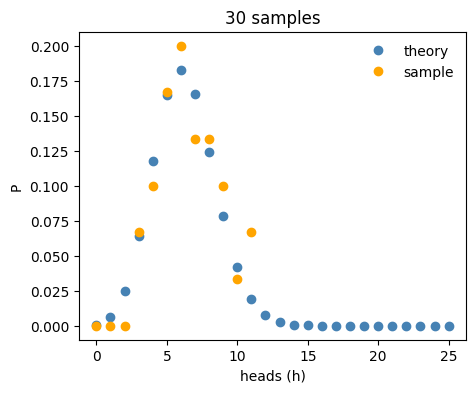

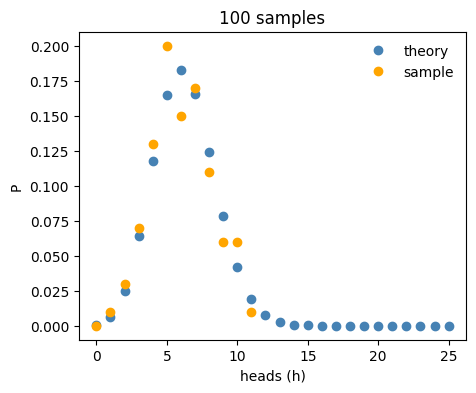

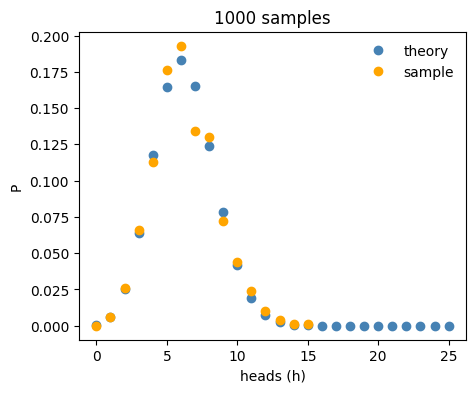

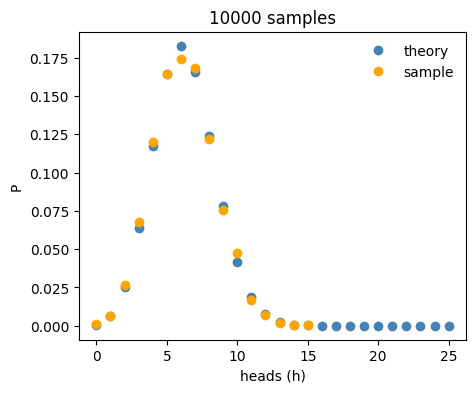

In [2]:
def simulate_coinflips(n, p, sample_size=1):
    """
    Simulate sample_size samples of n coin flips with prob. p of heads.
    
    Returns: vector of number of heads
    """
    n_heads = np.empty(sample_size, dtype=int)
    for i in range(sample_size):
        n_heads[i] = np.sum(np.random.random(size=n) < p)
    return n_heads


sample_size = (30, 100, 1000, 10000)
n = 25
p = 0.25

# get theoretical dsitribution
h_plot = np.arange(n+1)
theor_dist = st.binom.pmf(h_plot, n, p)

# sample
for n_samp in sample_size:
    plt.figure(figsize=figsize)
    plt.xlabel("heads (h)"),
    plt.ylabel("P")
    plt.title(f"{n_samp} samples")
    
    # plot theoretical distribution
    plt.plot(h_plot, theor_dist,
             'o',
             color="steelblue",
             label="theory")
    
    # get sampled distribution
    h = simulate_coinflips(n, p, sample_size=n_samp)
    # histogram samples
    avg_dist = np.bincount(h) / n_samp
        
    plt.plot(
        np.arange(h.max() + 1), avg_dist,
        'o',
        color="orange",
        label="sample"
    )
    plt.legend(frameon=False)


As we can see, if we *sample* out of the probability distribution, we can approximately calculate the actual distribution. If we sample enough, the approximation is very good.

Sampling is such a powerful strategy that highly efficient algorithms with convenient APIs have been developed to sample out of named probability distributions. For example, we could have used `np.random.binom()` as a drop-in (and _much_ more efficient) replacement for the `simulate_coinflips()` function above.

## Sampling from Chemical Master equations

We will use the same strategy for solving the master equations of systems that we describe in terms of reactions.
We will find a way to *sample* out of the distribution that is governed by the master equation.
This technique was pioneered by Dan Gillespie in the last 70s. For that reason, these sampling techniques are often called **Gillespie simulations**. The algorithm is sometimes referred to as a **stochastic simulation algorithm**, or **SSA**.

Here, we will explore how this algorithm works by looking at simple production of a protein.

## The dynamical equations

For simple protein production, we have the following species
* DNA. We assume there is a single promoter followed by a protein-coding gene in the cell
* mRNA, where $m$ is the current number of mRNA corresponding to the above gene
* protein, where $p$ is the current number of proteins corresponding to the above gene

as well as the following reactions among them:
\begin{align}
\text{DNA}  &\rightarrow \text{mRNA} &\text{(transcription)}\\
\text{mRNA}  &\rightarrow \emptyset &\text{(mRNA degradation and dilution)}\\
\text{mRNA} &\rightarrow \text{protein} &\text{(translation)}\\
\text{protein} &\rightarrow \emptyset &\text{(protein degradation and dilution)}
\end{align}

### Macroscale equations (deterministic, ODE semantics)
As we've seen before, the deterministic dynamics, which describe mean concentrations over a large population of cells, are described by the ODEs

\begin{align}
\frac{\mathrm{d}m}{\mathrm{d}t} &= \beta_m - \gamma_m m, \\[1em]
\frac{\mathrm{d}p}{\mathrm{d}t} &= \beta_p m - \gamma_p p.
\end{align}

The same equations should hold if $m$ and $p$ represent the mean *numbers* of cells; we would just have to appropriately rescale the constants. Assuming the $m$ and $p$ are now numbers (so we are not free to pick their units), we can nondimensionalize using $\gamma_m$ to nondimensionalize time. This leads to redefinition of parameters and variables

\begin{align}
&\beta_m/\gamma_m \to \beta_m, \\[1em]
&\beta_p/\gamma_m \to \beta_p, \\[1em]
&\gamma_m t \to t.
\end{align}

The dimensionless equations are

\begin{align}
\frac{\mathrm{d}m}{\mathrm{d}t} &= \beta_m - m, \\[1em]
\frac{\mathrm{d}p}{\mathrm{d}t} &= \beta_p m - \gamma p,
\end{align}

with $\gamma = \gamma_p/\gamma_m$.

### The Chemical Master equation (stochastic, Markov chain semantics)

We can write a master equation for these dynamics.  In this case, each state is defined by an mRNA copy number $m$ and a protein copy number $p$.
States can transition to other states with rates.
We assume that the state fully described the system state.
That is the probability to transition from a state $(m,p)$ to a state $(m',p')$ with in an infinitesimal time $\Delta t$
is independent if how long our system already is in state $(m,p)$.
It is approximately $\Delta \cdot \gamma_i(m,p)$, where $\gamma_i(m,p)$ is the rate at which reaction $i$ happens if in state $(m,p)$.

The following image shows state transitions and their corresponding reactions for large enough $m$ and $p$.
Care has to be taken at the boundaries, e.g., if $m = 1$ or $m = 0$.

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/markov.svg" alt="Markov chain">
</figure>

</div>

Denote by **$P(m, p, t)$** the probability that the system is in state $(m,p)$ at time $t$.
Then, by letting $\Delta t \to 0$, it is

\begin{align}
\frac{\mathrm{d}P(m,p,t)}{\mathrm{d}t}  &= \beta_m P(m-1,p,t) & \text{(from left)}\\
                                        &+ (m+1)P(m+1,p,t) & \text{(from right)}\\
                                        &+\beta_p mP(m,p-1,t) & \text{(from bottom)}\\
                                        &+ \gamma (p+1)P(m,p+1,t) &\text{(from top)}\\
                                        &- mP(m,p,t) & \text{(to left)}\\
                                        &- \beta_m P(m,p,t) & \text{(to right)}\\
                                        &- \gamma p P(m,p,t) &\text{(to bottom)}\\
                                        &- \beta_p mP(m,p,t)\enspace. & \text{(to top)}
\end{align}

We implicitly define $P(m, p, t) = 0$ if $m < 0$ or $p < 0$. This is the master equation we will sample from using the stochastic simulation algorithm (SSA) also called Gillespie algorithm.

## The Gillespie algorithm

### Propensity
The rhs terms in the above equation are familiar to us: they almost look like reaction rates with a single difference of not being functions of *concentrations*, but of *species counts*.
For example, a reaction
$$
A + B \rightarrow C
$$
with mass-action kinetics and rate constant $\gamma$ in units of $\text{L} s^{-1}$
has **rate**
$$
\gamma \cdot [A] \cdot [B]
$$
in units of $\text{L}^{-2} \cdot \text{L} \text{s}^{-1} = \text{L}^{-1} \text{s}^{-1}$.
Concentrations may as well be given in [molar units](https://en.wikipedia.org/wiki/Molar_concentration).

By contrast, the **propensity** of the reaction is
$$
\gamma' \cdot A \cdot B
$$
in units of $\text{s}^{-1}$, where
$\gamma' = \gamma / \text{vol}$ is in units of $\text{s}^{-1}$
and vol is the volume of the compartment in which the reactions happen.

The propensity for a given transition/reaction, say indexed $i$, is denoted as $a_i$.
The equivalence to notation we introduced for master equations is that if transition $i$ results in the change of state from $n'$ to $n$, then $a_i = W(n\mid n')$.

### Switching states: transition probabilities and transition times 
To cast this problem for a Gillespie simulation, we can write each change of state (moving either the copy number of mRNA or protein up or down by 1 in this case) and their respective propensities.

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{propensity, } a_i \\
m \rightarrow m+1,\;\;\;\; & \beta_m \\[0.3em]
m \rightarrow m-1, \;\;\;\; & m\\[0.3em]
p \rightarrow p+1, \;\;\;\; & \beta_p m \\[0.3em]
p \rightarrow p-1, \;\;\;\; & \gamma p\enspace.
\end{array}
\end{align}

We will not carefully prove that the Gillespie algorithm samples from the probability distribution governed by the master equation, but will state the principles behind it.  The basic idea is that events (such as those outlined above) are rare, discrete, separate events.  I.e., each event is an arrival of a Poisson process.  The Gillespie algorithm starts with some state, $(m_0,p_0)$.  Then a state change, *any* state change, will happen in some time $\Delta t$ that has a certain probability distribution (which we will show is exponential momentarily).

####  transition probabilities
The probability that the state change that happens is because of reaction $j$ is proportional to $a_j$.
That is to say, state changes with high propensities are more likely to occur.
Thus, choosing which of the $k$ state changes happens in $\Delta t$ is a matter of drawing an integer $j \in [1,k]$ where the probability of drawing $j$ is

\begin{align}
\frac{a_j}{\sum_i a_i}\enspace.
\end{align}

####  transition times
Now, how do we determine how long the state change took?
Let $T_i(m,p)$ be the stochastic variable that is the time that reaction $i$ occurs in state $(m,p)$, given that it is reaction
  $i$ that results in the next state.
The probability density function $p_i$ for the stochastic variable $T_i$, is
\begin{align}
p_i(t) = a_i\, \mathrm{e}^{-a_i t}\enspace,
\end{align}
for $t \geq 0$, and $0$ otherwise.
This is known as the [exponential distribution](https://www.randomservices.org/random/poisson/Exponential.html) with rate parameter $a_i$ (related, but not equal to the rate of the reaction).

The probability that it has *not* occurred by time $\Delta t$, is thus
\begin{align}
P(T_i(m,p) > \Delta t \mid \text{reaction } r_i \text{ occurs}) = \int_{\Delta t}^\infty p_i(t) \mathrm{d}t = \mathrm{e}^{-a_i \Delta t}\enspace.
\end{align}

However, in state $(m,p)$ there are several reactions that may make the system transition to the next state.
Say we have $k$ reactions that arrive at times $t_1, t_2, \ldots$.
When does the first one of them arrive?

The probability that *none* of them arrive before $\Delta t$ is
\begin{align}
P(t_1 > \Delta t \wedge t_2 > \Delta t \wedge \ldots) &=
P(t_1 > \Delta t) P(t_2 > \Delta t) \cdots =
\prod_i \mathrm{e}^{-a_i \Delta t} 
= \mathrm{exp}\left(-\Delta t \sum_i a_i\right)\enspace.
\end{align}
This is the equal to $P(T(m,p) > \Delta t \mid \text{reaction } R \text{ occurs})$ for a reaction $R$ with
  propensity $\sum_i a_i$.
For such a reaction the occurrence times are exponentially distributed with rate parameter $\sum_i a_i$.

### The algorithm
So, we know how to choose a state change and we also know how long it takes.
The Gillespie algorithm then proceeds as follows.

1. Choose an initial condition, e.g., $m = p = 0$.
2. Calculate the propensity for each of the enumerated state changes.  The propensities may be functions of $m$ and $p$, so they need to be recalculated for every $m$ and $p$ we encounter.
3. Choose how much time the reaction will take by drawing out of an exponential distribution with a mean equal to $\left(\sum_i a_i\right.)^{-1}$.  This means that a change arises from a Poisson process.
4. Choose what state change will happen by drawing a sample out of the discrete distribution where $P_i = \left.a_i\middle/\left(\sum_i a_i\right)\right.$.  In other words, the probability that a state change will be chosen is proportional to its propensity.
5. Increment time by the time step you chose in step 3.
6. Update the states according to the state change you choose in step 4.
7. If $t$ is less than your pre-determined stopping time, go to step 2. Else stop.

Gillespie proved that this algorithm samples the probability distribution described by the master equation in his seminal papers in [1976](https://doi.org/10.1016/0021-9991(76)90041-3) and [1977](http://doi.org/10.1021/j100540a008). (We recommend reading the latter.) You can also read a concise discussion of how the algorithm samples the master equation in [Section 4.2 of Del Vecchio and Murray](http://www.cds.caltech.edu/~murray/books/AM08/pdf/bfs-stochastic_14Sep14.pdf).

## Implementing the Gillespie algorithm

To code up the Gillespie simulation, we first make an array that gives the changes in the counts of $m$ and $p$ for each of the four reactions.  This is a way of encoding the updates in the particle counts that we get from choosing the respective state changes.

In [3]:
# Column 0 is change in m, column 1 is change in p

# (m,p)

simple_update = np.array(
    [
        [1, 0],  # Make mRNA transcript
        [-1, 0],  # Degrade mRNA
        [0, 1],  # Make protein
        [0, -1],  # Degrade protein
    ],
    dtype=int,
)

### Updating propensities (Step 2)
Next, we make a function that updates the array of propensities for each of the four reactions. We update the propensities (which are passed into the function as an argument) instead of instantiating them and returning them to save on memory allocation while running the code. It has the added benefit that it forces you to keep track of the indices corresponding to the update matrix. This helps prevent bugs. It will naturally be a function of the current population of molecules. It may in general also be a function of time, so we explicitly allow for time dependence (even though we will not use it in this simple example) as well.

In [4]:
def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population

    # Update propensities
    propensities[0] = beta_m  # Make mRNA transcript
    propensities[1] = m  # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p  # Degrade protein

### Time until reaction (Step 3)

First, to get the time until a reaction occurs, we sample a random number from an exponential distribution with rate parameter $\left(\sum_i a_i\right)$, i.e., mean $\left(\sum_i a_i\right)^{-1}$.
This is easily done using the `np.random.exponential()` function.  

### Determine which reaction occurs (Step 4)

Next, we have to select which reaction will take place.  This amounts to drawing a sample over the discrete distribution where $P_i = a_i\left(\sum_i a_i\right)^{-1}$, or the probability of each reaction is proportional to its propensity.  This can be done using `scipy.stats.rv_discrete`, which allows specification of an arbitrary discrete distribution.  We then use `rvs()` on this object to sample the distribution once.

In [5]:
# probs = [0.1, 0.1, 0.3, 0.5]

def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

# alternative: 
# draw q = 0.4
# 0.1 < q
# 0.1 + 0.1 = 0.2 < q
# 0.2 + 0.3 = 0.5 >= q -> take it

This is a nice one-liner, but is it fast? There may be significant overhead in setting up the `scipy.stats` discrete random variable object to sample from each time. Remember, we can't just do this once because the array `probs` changes with each step in the SSA because the propensities change. We will therefore write a less elegant, but maybe faster way of doing it.  

Another way to sample the discrete distribution is to generate a uniformly distributed random number $q \sim \text{Uniform}(0,1)$ within bounds $0$ and $1$,
and return the value $j$ such that

\begin{align}
\sum_{i=0}^{j-1} p_i < q < \sum_{i=0}^{j}p_i.
\end{align}

We'll code this up.

In [6]:
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

Now let's compare the speeds using the `%timeit` function. This is a useful tool to help diagnose slow spots in your code.

In [7]:
# Make dummy probs
probs = np.array([0.1, 0.3, 0.4, 0.05, 0.15])

print('Result from scipy.stats:')
%timeit sample_discrete_scipy(probs)

print('\nResult from hand-coded method:')
%timeit sample_discrete(probs)

Result from scipy.stats:
237 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Result from hand-coded method:
577 ns ± 0.902 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Wow!  The less concise method is a couple of orders of magnitude faster!  So, we will ditch using `scipy.stats`, and use our hand-built sampler instead.

Now we can write a function to do our draws.

In [8]:
def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    propensities : ndarray
        Propensities for each reaction as a 1D Numpy array.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # sample time step
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

## SSA time stepping

Now we are ready to write our main SSA loop.  We will only keep the counts at pre-specified time points. This saves on RAM, and we really only care about the values at given time points anyhow.

Note that this function is generic. All we need to specify our system is the following.

* A function to compute the propensities
* How the updates for a given reaction are made
* Initial population

Additionally, we specify necessary parameters, an initial condition, and the time points at which we want to store our samples. So, providing the propensity function and update are analogous to providing the time derivatives when using `scipy.integrate.odeint()`.

In [9]:
def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]  # set time to initial time
    population = population_0.copy()
    pop_out[0, :] = population  # output the first population counts
    propensities = np.zeros(update.shape[0])
    
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(
                propensity_func, propensities, population, t, args
            )

            # Update the population
            population_previous = population.copy()
            population += update[event, :]

            # Increment time
            t += dt

        # Update the index
        # i = np.searchsorted(time_points > t, True)
        i = np.sum(time_points <= t)

        # Update the population
        pop_out[i_time : min(i, len(time_points))] = population_previous

        # Increment index
        i_time = i

    return pop_out

## Running and parsing results

We can now run a set of SSA simulations and plot the results.  We will run 100 trajectories and store them, using $\beta_p = \beta_m = 10$ and $\gamma = 0.4$. We will also use the nifty package `tqdm` to give a progress bar so we know how long it is taking.

In [10]:
# Specify parameters for calculation
args = (10.0, 10.0, 0.4)                    # the rate constants
time_points = np.linspace(0, 50, 101)       # output times
population_0 = np.array([0, 0], dtype=int)  # initial counts
n_trajectories = 100                        # how many trajectories we want

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((n_trajectories, len(time_points), 2), dtype=int)

# Run the calculations
for i in tqdm.tqdm(range(n_trajectories)):
    samples[i, :, :] = gillespie_ssa(
        simple_propensity, simple_update, population_0, time_points, args=args
    )

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.54it/s]


We now have our samples, so we can plot the trajectories. For visualization, we will plot every trajectory as a thin blue line, and then the average of the trajectories as a thick orange line.

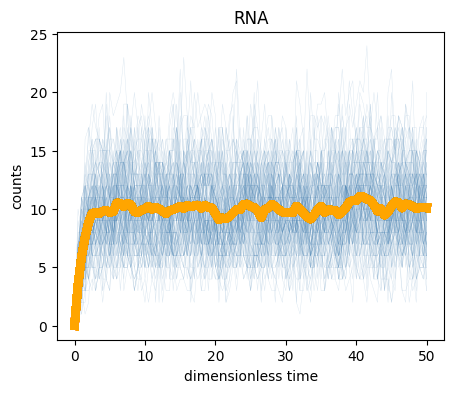

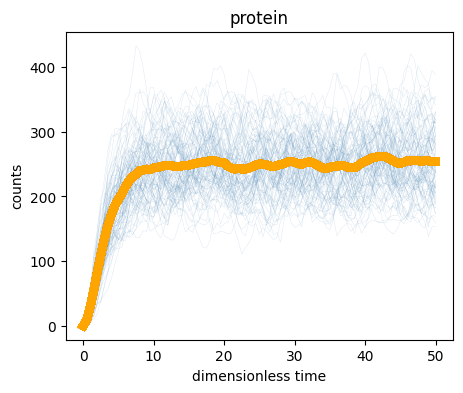

In [11]:
# Plot trajectories and mean
for i, name in enumerate(["RNA", "protein"]):
    plt.figure(figsize=figsize)
    plt.xlabel("dimensionless time")
    plt.ylabel("counts")
    plt.title(name)

    for x in samples[:, :, i]:
        plt.plot(
            time_points,
            x,
            lw=0.3,
            alpha=0.2,
            color="steelblue",
        )
        plt.plot(
            time_points,
            samples[:, :, i].mean(axis=0),
            lw=6,
            color="orange",
        )

We can also compute the steady state properties by considering the end of the simulation.  The last 50 time points are at steady state, so we will average over them.

In [12]:
print("mRNA mean copy number =", samples[:, -50:, 0].mean())
print("protein mean copy number =", samples[:, -50:, 1].mean())

print("\nmRNA variance =", samples[:, -50:, 0].std() ** 2)
print("protein variance =", samples[:, -50:, 1].std() ** 2)

print("\nmRNA CV =", samples[:, -50:, 0].std() / samples[:, -50:, 0].mean())
print(
    "protein CV =", samples[:, -50:, 1].std() / samples[:, -50:, 1].mean()
)

mRNA mean copy number = 10.0748
protein mean copy number = 251.6994

mRNA variance = 10.26200496
protein variance = 2145.33703964

mRNA CV = 0.317965262817717
protein CV = 0.18402023679851773


### Steady state
Finally, we can compute the steady state probability distributions.
To plot them, we plot the empirical probability density function (EPDF) from the sampling.

#### Inline Q:
Which steady state would you expect for mRNA and proteins from the ODE?
Let's check if they match.

A Poisson distribution with this mean has been overlayed for mRNA.

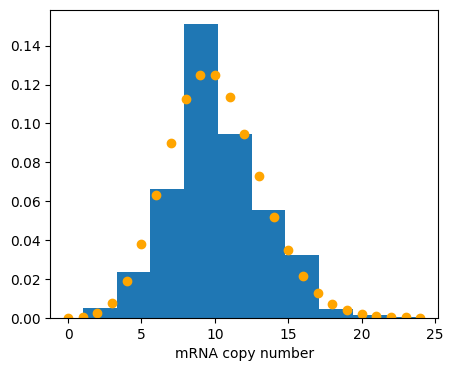

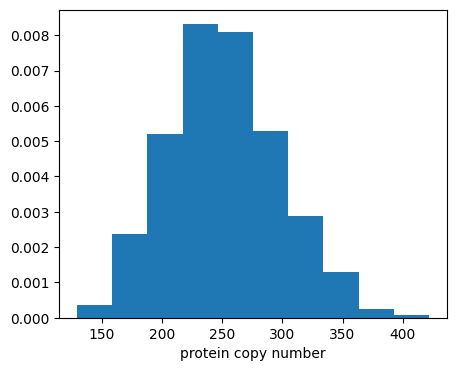

In [13]:
def epdf(vals, xlabel):
    plt.xlabel(xlabel)
    plt.hist(vals, density=True)

# mRNA ECDF
plt.figure(figsize=figsize)
epdf(
    samples[:, -50:, 0].flatten(),
    xlabel="mRNA copy number",
)

# Theoretial mRNA pdf/pmf (Poisson)
x = np.arange(25)
plt.plot(
    x,
    st.poisson.pmf(x, args[0]),
    'o',
    color="orange"
)

# protein ECDF
plt.figure(figsize=figsize)
epdf(
    samples[:, -50:, 1].flatten(),
    xlabel="protein copy number",
)


As we expect, the mRNA copy number matches the Poisson distribution. We also managed to get a distribution for the protein copy number that we could plot. 

You now have the basic tools for doing Gillespie simulations. You just need to code the propensity function and the update, and you're on your way! (Note, though, that this only works for Gillespie simulations where the states are defined by particle counts, which should suffice for this course.)

## Increasing speed

In this section of the tutorial, we briefly discuss some strategies for boosting the speed of your Gillespie simulation.

A significant speed boost is achieved by [just-in-time compliation](https://en.wikipedia.org/wiki/Just-in-time_compilation) using [Numba](http://numba.pydata.org). To utilize this feature, you need to just-in-time compile (JIT) your propensity function. You can insist that everything is compiled (and therefore skip the comparably slow Python interpreter) by using the `@numba.njit` decorator. In many cases, like in this one for simple gene expression, that is all you have to do.

In [14]:
@numba.njit
def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population

    # Update propensities
    propensities[0] = beta_m  # Make mRNA transcript
    propensities[1] = m  # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p  # Degrade protein

Let us try it out and get 1000 samples.

In [15]:
n_trajectories = 1000

samples = np.empty((n_trajectories, len(time_points), 2), dtype=int)

for i in tqdm.tqdm(range(n_trajectories)):
    samples[i, :, :] = gillespie_ssa(
        simple_propensity,
        simple_update,
        population_0,
        time_points,
        args=args
    )

100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.92it/s]


We now have 1000 trajectories, and we can again make the plots as we did before. With so many trajectories, though, we should not show them all, since there would be too many glyphs on the plot. We therefore thin out the samples for plotting, taking only every 100th trajectory.

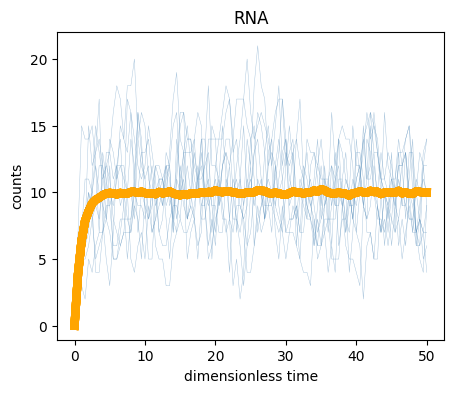

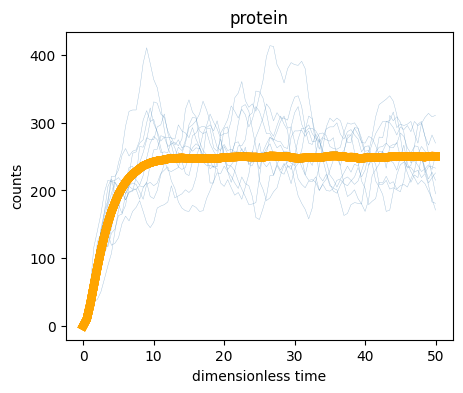

In [16]:
# Plot trajectories and mean
for i, name in enumerate(["RNA", "protein"]):
    plt.figure(figsize=figsize)
    plt.xlabel("dimensionless time")
    plt.ylabel("counts")
    plt.title(name)

    for x in samples[::100, :, i]:
        plt.plot(
            time_points,
            x,
            lw=0.3,
            alpha=0.5,
            color="steelblue",
        )
        plt.plot(
            time_points,
            samples[:, :, i].mean(axis=0),
            lw=6,
            color="orange",
        )

### Computing the Propensity

An obvious speed improvement can be made by only recalculating the propensity for copy numbers we have not visited.
For example, for simple gene expression, we do not need to recompute the propensity for mRNA decay if the previous move was a protein decay. The propensity for mRNA decay is the same it was at the previous step. Gibson and Bruck developed the [next reaction method](http://doi.org/10.1021/jp993732q), which makes these improvements, among others, and can result in significant speed-up for complicated sets of reactions. Instead of wading into the algorithmic details, we will instead investigate how we can speed up our implementation of the direct Gillespie algorithm.

### Let's compare

We will first remake the non-JITted version of the propensity function to test its speed.

In [17]:
def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population

    # Update propensities
    propensities[0] = beta_m  # Make mRNA transcript
    propensities[1] = m  # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p  # Degrade protein

Let's do some profiling to see what took so long.  We will use the magic function `%lprun` to profile runs of SSAs.  The output has line wrapping, so it is kind of hard to read in a Jupyter notebook, unfortunately.
We use the `-f` flag to specify which function to profile linewise.

In [18]:
%lprun -T lp_results.txt -f gillespie_ssa gillespie_ssa(\
        simple_propensity, simple_update, population_0, time_points, args)


*** Profile printout saved to text file 'lp_results.txt'. 


Timer unit: 1e-09 s

Total time: 0.110468 s
File: /var/folders/nr/_hn8w4_n1_39r9hhv2c600040000gp/T/ipykernel_94786/870969235.py
Function: gillespie_ssa at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
     2                                               """
     3                                               Uses the Gillespie stochastic simulation algorithm to sample
     4                                               from probability distribution of particle counts over time.
     5                                               
     6                                               Parameters
     7                                               ----------
     8                                               propensity_func : function
     9                                                   Function of the form f(params, t, populati

We see that 80% of the time is spent doing draws.  Nothing else is really worth looking at.  Let's see how we can improve our draw speed.

In [19]:
propensities = np.ones(4)

%lprun -T lp_results.txt -f gillespie_draw \
        [gillespie_draw(simple_propensity, propensities, population_0, 0, args) \
            for _ in range(10000)]


*** Profile printout saved to text file 'lp_results.txt'. 


Timer unit: 1e-09 s

Total time: 0.080953 s
File: /var/folders/nr/_hn8w4_n1_39r9hhv2c600040000gp/T/ipykernel_94786/267624423.py
Function: gillespie_draw at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def gillespie_draw(propensity_func, propensities, population, t, args=()):
     2                                               """
     3                                               Draws a reaction and the time it took to do that reaction.
     4                                               
     5                                               Parameters
     6                                               ----------
     7                                               propensity_func : function
     8                                                   Function with call signature propensity_func(population, t, *args)
     9                                                   used for computing propensities. This

The propensity function is taking the most time. We will focus on improving that.

### Speed boost by JIT compilation with Numba

As we have seen [Numba](https://numba.pydata.org) is a package that does LLVM optimized just-in-time compilation of Python code.  The speed-ups can be substantial.  We will use `numba` to compile the parts of the code that we can.  For many functions, we just need to decorate the function with

    @numba.jit()

and that is it.  If possible, we can use the `nopython=True` keyword argument to get more speed because the compiler can assume that all of the code is JIT-able. Note that using

    @numba.njit
    
is equivalent to using `@numba.jit(nopython=True)`.

In [20]:
@numba.njit
def simple_propensity_numba(
    propensities, population, t, beta_m, beta_p, gamma
):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population

    # Update propensities
    propensities[0] = beta_m  # Make mRNA transcript
    propensities[1] = m  # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p  # Degrade protein

    
# Check speeds
print('Old propensity function:')
%timeit simple_propensity(propensities, population_0, 0, *args)

print('\nNumba\'d propensity function:')
%timeit simple_propensity_numba(propensities, population_0, 0, *args)

Old propensity function:
1.94 µs ± 18.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

Numba'd propensity function:
252 ns ± 0.927 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


We got some speed up! Nice! 

Now, we also saw that the sums and division of arrays are slow. Let's optimize the sum operation using `numba`.

In [21]:
@numba.njit
def sum_numba(ar):
    return ar.sum()


# Make dummy array for testing
ar = np.array([0.3, 0.4, 0.3, 0.2, 0.15])

print('\nNumPy sum:')
%timeit ar.sum()

print('\nNumba sum:')
%timeit sum_numba(ar)


NumPy sum:
632 ns ± 2.13 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)

Numba sum:
119 ns ± 0.327 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


We get another speed boost, though we should note that this speed boost in the sum is due to `numba` optimizing sums of a certain size.  For sums over large numbers of entries, `numba`'s performance will not exceed NumPy's by much at all.

Finally, we will speed up the sampling of the discrete distribution.  We will do this in two ways.  First, we notice that the division operation on the propensities took a fair amount of time when we profiled the code.  We do not need it; we can instead sample from an unnormalized discrete distribution.  Secondly, we can use `numba` to accelerate the while loop in the sampling.

In [22]:
@numba.njit
def sample_discrete_numba(probs, probs_sum):
    q = np.random.rand() * probs_sum

    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1


# Make dummy unnormalized probs
probs = np.array([0.1, 0.3, 0.4, 0.05, 0.15, 0.6])
probs_sum = sum_numba(probs)

print('Result from hand-coded method:')
%timeit sample_discrete(probs)

print("\nResults from numba'd version:")
%timeit sample_discrete_numba(probs, probs_sum)

Result from hand-coded method:
573 ns ± 3.51 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)

Results from numba'd version:
159 ns ± 0.156 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


We get a speed-up of about a factor of three.  Let's now make a new `gillespie_draw()` function that is faster.  The fast propensity function is just an argument to the fast draw-er.

In [23]:
def gillespie_draw_fast(propensity_func, propensities, population, t, args):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = sum_numba(propensities)
    
    # Compute time
    time = np.random.exponential(1 / props_sum)

    # Draw reaction given propensities
    rxn = sample_discrete_numba(propensities, props_sum)
    
    return rxn, time


print('Old Gillespie draw:')
%timeit gillespie_draw(simple_propensity, propensities, population_0, 0.0, args)

print('\nFast Gillespie draw:')
%timeit gillespie_draw_fast(simple_propensity_numba, propensities, population_0, 0.0, args)

Old Gillespie draw:
4.15 µs ± 23.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

Fast Gillespie draw:
921 ns ± 2.63 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


So, our optimization got us another speed boost.  Let's adjust our SSA function to include the fast draws.

In [24]:
def gillespie_ssa_fast(
    propensity_func, update, population_0, time_points, args=()
):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func. 
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0, :] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw_fast(
                propensity_func, propensities, population, t, args
            )

            # Update the population
            population_previous = population.copy()
            population += update[event, :]

            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)

        # Update the population
        pop_out[i_time : min(i, len(time_points))] = population_previous

        # Increment index
        i_time = i

    return pop_out

Now we can test the speed of the two SSAs.

In [25]:
print('Gillespie SSA:')
%timeit gillespie_ssa(simple_propensity, simple_update, \
                      population_0, time_points, args)

print('\nFast Gillespie SSA:')
%timeit gillespie_ssa_fast(simple_propensity_numba, simple_update,\
                           population_0, time_points, args)

Gillespie SSA:
55 ms ± 661 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Fast Gillespie SSA:
17.4 ms ± 57.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So, we are now faster with not too much work. This is still a general solver that you can use with any propensity function and update.

We have constructed a generic tool for doing Gillespie simulations.  Specifically, we pass a propensity function into the algorithm. Passing a function as an argument precludes use of `numba`. This means that we cannot just-in-time compile the entire Gillespie simulation. We could insist that our propensity function be encoded in a global function `prop_func()`, then we can fully JIT compile the entire simulation. (Note that there are ways to get around this insistence on a global function, but for the purposes of this demonstration, it is convenient.)

In [26]:
@numba.njit
def prop_func(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population
    
    # Update propensities
    propensities[0] = beta_m      # Make mRNA transcript
    propensities[1] = m           # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p   # Degrade protein


@numba.njit
def gillespie_draw_numba(propensities, population, t, args):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Assumes that there is a globally scoped function
    `prop_func` that is Numba'd with nopython=True.
    """
    # Compute propensities
    prop_func(propensities, population, t, *args)

    # Sum of propensities
    props_sum = np.sum(propensities)
    
    # Compute time
    time = np.random.exponential(1 / props_sum)
    
    # Draw reaction given propensities
    rxn = sample_discrete_numba(propensities, props_sum)

    return rxn, time


@numba.njit
def gillespie_ssa_numba(update, population_0, time_points, args):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
        
    Notes
    -----
    .. Assumes that there is a globally scoped function
       `propensity_func` that is Numba'd with nopython=True.
    """
    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int64)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw_numba(propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index (Have to be careful about types for Numba)
        i = np.searchsorted((time_points > t).astype(np.int64), 1)

        # Update the population
        for j in np.arange(i_time, min(i, len(time_points))):
            pop_out[j,:] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

Now let's test the speed of all three of our functions.

In [27]:
print('Gillespie SSA:')
%timeit gillespie_ssa(simple_propensity, simple_update, \
                      population_0, time_points, args)

print('\nFast Gillespie SSA:')
%timeit gillespie_ssa_fast(simple_propensity_numba, simple_update,\
                            population_0, time_points, args)

print('\nTotally numba\'d Gillespie SSA:')
%timeit gillespie_ssa_numba(simple_update, population_0, time_points, args)

Gillespie SSA:
55.1 ms ± 902 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Fast Gillespie SSA:
17.3 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Totally numba'd Gillespie SSA:
810 µs ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


We got an extra order of magnitude speed boost by totally JIT compiling everything. The speed up is significant, so we should probably use Numba'd code.

## Parallel Gillespie simulations

Sampling by the Gillespie algorithm is trivially parallelizable. We can use the `joblib` module to parallelize the computation. Syntactically, we need to specify a function that takes a single argument. Below, we set up a parallel calculation of Gillespie simulations for our specific example.

In [28]:
def gillespie_fn(args):
    return gillespie_ssa_numba(*args)
    
    
def gillespie_parallel(fn, update, population_0, time_points, args,
                       n_simulations, n_jobs):
    """
    Convenience function to do parallel Gillespie simulations.
    """
    input_args = (update, population_0, time_points, args)

    populations = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(gillespie_fn)(input_args) for _ in range(n_simulations)
    )
        
    return np.array(populations)

We are paying some overhead in setting up the parallelization.  Let's time it to see how we do with parallelization.

In [29]:
n_simulations = 1000

print('\nnumba\'d Gillespie SSA:')
%timeit [gillespie_ssa_numba(simple_update, population_0, time_points, args) \
            for _ in range(n_simulations)]

print('\nParallel numba\'d Gillespie SSA:')
print(f'core count = {joblib.cpu_count()}')
%timeit gillespie_parallel(gillespie_fn, simple_update, population_0, time_points,\
                           args, n_simulations, 4)


numba'd Gillespie SSA:
807 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Parallel numba'd Gillespie SSA:
core count = 8
236 ms ± 715 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


We get another speed boost. This brings our total speed boost from the optimization to near two orders of magnitude.

### Heuristics to further improve speed

If we insist on *exact* sampling out of a probability distribution defined by a master question, we can get significant speed boosts by switching to the [Gibson and Bruck algorithm](http://doi.org/10.1021/jp993732q), especially for more complicated systems and propensity functions. If we are willing to *approximately* sample out of the probability distribution, there are many fast, approximate methods (e.g., [Salis and Kaznessis](https://doi.org/10.1063%2F1.1835951)) available.

## Simulating the repressilator

We have seen a structure to how we can set up Gillespie simulations; we need to specify the propensities and updates, along with an initial population. It helps clarify the system being simulated and also avoids bugs if we make tables for

1. The species whose populations we are describing;
2. The update-propensity pairs;
3. The parameter values.

After constructing the tables, coding up the update and propensity functions is much easier.

To demonstrate this procedure, we will perform a Gillespie simulation for the repressilator, as described in [Elowitz and Leibler](https://doi.org/10.1038/35002125). We will consider both RNA and DNA in a repressilator where gene 1 represses gene 2, gene 2 represses gene 3, and gene 3 represses gene 1. We explicitly consider mRNA and protein. A repressor binds its operon with chemical rate constant $k_r$, and an operon may have zero, one, or two repressors bound. The unbinding rate of a repressor when one is bound is $k_{u,1}$ and that of a repressor when two are bound is $k_{u,2}$, with $k_{u,2} < k_{u,1}$ to capture cooperativity. Transcription happens when no repressors are bound to a promoter region with rate constant $k_{m,u}$ and happens when one or two repressors are bound with rate $k_{m,o}$.

As we build the simulation, let's start with a table of the populations we are keeping track of.

|index|description | variable|
|:----:|:------ |:------: |
|0|gene 1 mRNA copy number | `m1`|
|1|gene 1 protein copy number | `p1`|
|2|gene 2 mRNA copy number | `m2`|
|3|gene 2 protein copy number | `p2`|
|4|gene 3 mRNA copy number | `m3`|
|5|gene 3 protein copy number | `p3`|
|6|Number of repressors bound to promoter of gene 3| `n1`|
|7|Number of repressors bound to promoter of gene 1| `n2`|
|8|Number of repressors bound to promoter of gene 2| `n3`|

Note that we labeled each species with an index, which corresponds to its position in the array of populations in the simulation.

Next, we can set up a table of updates and propensities for the moves we allow in the Gillespie simulation. We also assign an index to each entry here, as this helps keep track of everything.

|index|description | update | propensity|
|:----|:------ |:------ | :----:|
|0|transcription of gene 1 mRNA| `m1 -> m1 + 1`| `kmu*(n3 == 0) + kmo*(n3 > 0)`|
|1|transcription of gene 2 mRNA| `m2 -> m2 + 1`| `kmu*(n1 == 0) + kmo*(n1 > 0)`|
|2|transcription of gene 3 mRNA| `m3 -> m3 + 1`| `kmu*(n2 == 0) + kmo*(n2 > 0)`|
|3|translation of gene 1 protein| `p1 -> p1 + 1`| `kp * m1`|
|4|translation of gene 2 protein| `p2 -> p2 + 1`| `kp * m2`|
|5|translation of gene 3 protein| `p3 -> p3 + 1`| `kp * m3`|
|6|degradation of gene 1 mRNA| `m1 -> m1 - 1`| `gamma_m * m1`|
|7|degradation of gene 2 mRNA| `m2 -> m2 - 1`| `gamma_m * m2`|
|8|degradation of gene 3 mRNA| `m3 -> m3 - 1`| `gamma_m * m3`|
|9|degradation of unbound gene 1 protein| `p1 -> p1 - 1` | `gamma_p * p1`|
|10|degradation of unbound gene 2 protein| `p2 -> p2 - 1` | `gamma_p * p2`|
|11|degradation of unbound gene 3 protein| `p3 -> p3 - 1` | `gamma_p * p3`|
|12|degradation of bound gene 1 protein| `n1 -> n1 - 1` | `gamma_p * n1`|
|13|degradation of bound gene 2 protein| `n2 -> n2 - 1` | `gamma_p * n2`|
|14|degradation of bound gene 3 protein| `n3 -> n3 - 1` | `gamma_p * n3`|
|15|binding of protein to gene 1 operator| `n3 -> n3 + 1`, `p3 -> p3 - 1`| `kr * p3 * (n3 < 2)`|
|16|binding of protein to gene 2 operator| `n1 -> n1 + 1`, `p1 -> p1 - 1`| `kr * p1 * (n1 < 2)`|
|17|binding of protein to gene 3 operator| `n2 -> n2 + 1`, `p2 -> p2 - 1`| `kr * p2 * (n2 < 2)`|
|18|unbinding of protein to gene 1 operator| `n3 -> n3 - 1`, `p3 -> p3 + 1`| `ku1*(n3 == 1) + 2*ku2*(n3 == 2)`|
|19|unbinding of protein to gene 2 operator| `n1 -> n1 - 1`, `p1 -> p1 + 1`| `ku1*(n1 == 1) + 2*ku2*(n1 == 2)`|
|20|unbinding of protein to gene 3 operator| `n2 -> n2 - 1`, `p2 -> p2 + 1`| `ku1*(n2 == 1) + 2*ku2*(n2 == 2)`|

Finally, we have parameters that were introduced in the propensities, so we should have a table defining them.

|parameter| value | units |
|:----|:------ |:------: |
|`kmu`| 0.5 | s$^{-1}$|
|`kmo`|5*10$^{-4}$  | s$^{-1}$|
|`kp`| 0.167 | molecules$^{-1}$ s$^{-1}$|
|`gamma_m`| 0.005776 | s$^{-1}$|
|`gamma_p`| 0.001155 | s$^{-1}$|
| `kr` | 1 |  molecules$^{-1}$ s$^{-1}$|
| `ku1` | 224 |  s$^{-1}$|
| `ku2` | 9 |  s$^{-1}$|

We have now clearly defined all of our parameters, updates, and propensities. With the initial population, out simulation is not completely defined. In practice, we recommend constructing tables like this (and including them in your publications!) if you are going to do Gillespie simulations in your work.

We are now tasked with coding up the propensities and the updates. Starting with the propensities, we recall the call signature of `propensity(propensities, population, t, *args)`, where the `args` are the parameters. It is clearest to list the arguments one at a time in the function definition. It is also much clearer to unpack the population into individual variables than to use indexing. Finally, when returning the array of propensities, we recommend having one propensity for each line indexed in order.

In [30]:
@numba.njit
def prop_func(
    propensities, population, t, kmu, kmo, kp, gamma_m, gamma_p, kr, ku1, ku2
):
    m1, p1, m2, p2, m3, p3, n1, n2, n3 = population

    propensities[0] = kmu if n3 == 0 else kmo
    propensities[1] = kmu if n1 == 0 else kmo
    propensities[2] = kmu if n2 == 0 else kmo
    propensities[3] = kp * m1
    propensities[4] = kp * m2
    propensities[5] = kp * m3
    propensities[6] = gamma_m * m1
    propensities[7] = gamma_m * m2
    propensities[8] = gamma_m * m3
    propensities[9] = gamma_p * p1
    propensities[10] = gamma_p * p2
    propensities[11] = gamma_p * p3
    propensities[12] = gamma_p * n1
    propensities[13] = gamma_p * n2
    propensities[14] = gamma_p * n3
    propensities[15] = kr * p3 * (n3 < 2)
    propensities[16] = kr * p1 * (n1 < 2)
    propensities[17] = kr * p2 * (n2 < 2)
    propensities[18] = ku1 * (n3 == 1) + 2 * ku2 * (n3 == 2)
    propensities[19] = ku1 * (n1 == 1) + 2 * ku2 * (n1 == 2)
    propensities[20] = ku1 * (n2 == 1) + 2 * ku2 * (n2 == 2)

Now, we can code up the update. The update is a matrix where entry `i,j` is the change in species `i` due to move `j`. Since we have indexes both the species and the moves (in the update/propensity table), we can include the indices when we define the update for clarity.

In [31]:
repressilator_update = np.array(
    [   # 0   1   2   3   4   5   6   7   8
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0], # 0
        [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # 1
        [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # 2
        [ 0,  1,  0,  0,  0,  0,  0,  0,  0], # 3
        [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # 4
        [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # 5
        [-1,  0,  0,  0,  0,  0,  0,  0,  0], # 6
        [ 0,  0, -1,  0,  0,  0,  0,  0,  0], # 7
        [ 0,  0,  0,  0, -1,  0,  0,  0,  0], # 8
        [ 0, -1,  0,  0,  0,  0,  0,  0,  0], # 9
        [ 0,  0,  0, -1,  0,  0,  0,  0,  0], # 10
        [ 0,  0,  0,  0,  0, -1,  0,  0,  0], # 11
        [ 0,  0,  0,  0,  0,  0, -1,  0,  0], # 12
        [ 0,  0,  0,  0,  0,  0,  0, -1,  0], # 13
        [ 0,  0,  0,  0,  0,  0,  0,  0, -1], # 14
        [ 0,  0,  0,  0,  0, -1,  0,  0,  1], # 15
        [ 0, -1,  0,  0,  0,  0,  1,  0,  0], # 16
        [ 0,  0,  0, -1,  0,  0,  0,  1,  0], # 17
        [ 0,  0,  0,  0,  0,  1,  0,  0, -1], # 18
        [ 0,  1,  0,  0,  0,  0, -1,  0,  0], # 19
        [ 0,  0,  0,  1,  0,  0,  0, -1,  0], # 20
    ],
    dtype=int)

Next, we specify the parameter values according to the parameter table. Remember that we need to package them in a tuple, after defining them.

In [32]:
# Parameter values
kmu = 0.5
kmo = 5e-4
kp = 0.167
gamma_m = 0.005776
gamma_p = 0.001155
kr = 1.0
ku1 = 224.0
ku2 = 9.0

repressilator_args = (kmu, kmo, kp, gamma_m, gamma_p, kr, ku1, ku2)

Finally, we specify the initial population and the time points we want for the sampling.

In [33]:
# State with 10 copies of everything, nothing bound to operators
repressilator_pop_0 = np.array([10, 10, 10, 10, 10, 10, 0, 0, 0], dtype=int)

repressilator_time_points = np.linspace(0, 80000, 4001)

And we are all set to perform the calculation. We will make a single trace and then plot it.

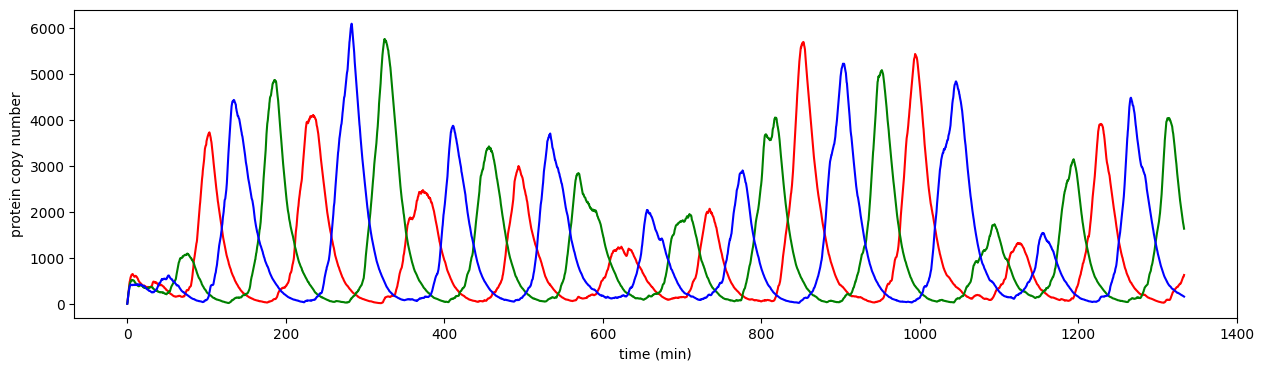

In [36]:
# Perform the Gillespie simulation
pop = gillespie_ssa_numba(
    repressilator_update,
    repressilator_pop_0,
    repressilator_time_points,
    args=repressilator_args,
)

# Make plot
colors = ["red", "green", "blue"]
plt.figure(figsize=(figsize[0]*3, figsize[1]))
plt.xlabel("time (min)")
plt.ylabel("protein copy number")
for c, i in enumerate([1, 3, 5]):
    plt.plot(repressilator_time_points / 60, pop[:, i], color=colors[c])

We observe the oscillations, but the amplitudes are highly variable.